In [130]:
import matplotlib.pyplot as plt
import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

In [43]:
import torch
from torch import nn, optim
from sklearn.datasets import load_digits

digits = load_digits()

In [54]:
X = digits.data
Y = digits.target
print(type(X),type(Y))

# Numpy의 ndarray를 파이토치의 텐서로 변환
X = torch.tensor(X, dtype = torch.float32)
Y = torch.tensor(Y, dtype = torch.int64)

print(type(X),type(Y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


In [55]:
net = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,10)
)

In [56]:
# 소프트맥스 크로스엔트로피
loss_fn = nn.CrossEntropyLoss()

# Adam
optimizer = optim.Adam(net.parameters())

# 손실함수의 로그
losses = []

In [57]:
# 100회 반복
for epoc in range(100):
    # backward 메서드로 계산된 이전값 삭제
    optimizer.zero_grad()
    # 선형모델로 y_pred 계산
    y_pred = net(X)
    # MSE와 w를 사용한 미분계산
    loss = loss_fn(y_pred,Y)
    loss.backward()
    # 경사를 갱신
    optimizer.step()
    # 수렴 확인을 위해 loss를 기록해둔다
    losses.append(loss.item())

In [59]:
X = X.to("cuda:0")
Y = Y.to("cuda:0")
net.to("cuda:0")

In [60]:
_, y_pred = torch.max(net(X),1)
(y_pred == Y).sum().item() / len(Y)

0.9371174179187535

In [61]:
X.shape , Y.shape

(torch.Size([1797, 64]), torch.Size([1797]))

In [62]:
# Dataset 작성
ds = TensorDataset(X,Y)

# 순서로 섞어서 64개씩 데이터를 반환하는 DataLoader 작성

loader = DataLoader(ds,batch_size = 64, shuffle = True)

net = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,10)
)

# 소프트맥스 크로스엔트로피
loss_fn = nn.CrossEntropyLoss()

# Adam
optimizer = optim.Adam(net.parameters())

In [63]:
losses = []
for epoch in range(10):
    running_loss = 0.0
    for xx, yy in loader:
        # xx, yy는 64개만 받는다
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss)

In [64]:
_, y_pred = torch.max(net(X),1)
(y_pred == Y).sum().item() / len(Y)

0.9755147468002225

In [93]:
from sklearn.model_selection import train_test_split
X = digits.data
Y = digits.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

X_train = torch.tensor(X_train, dtype = torch.long)
X_test = torch.tensor(X_test, dtype = torch.int64)
Y_train = torch.tensor(Y_train, dtype = torch.long)
Y_test = torch.tensor(Y_test, dtype = torch.int64)

k = 100

net = nn.Sequential(
    nn.Linear(64,k),
    nn.ReLU(),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.Linear(k,10)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# 훈련용 데이터로 DataLoader를 작성

ds = TensorDataset(X_train, Y_train)
loader = DataLoader(ds, batch_size = 32, shuffle = True)

In [101]:
train_losses = []
test_losses = []

for epoch in range(100):
    running_loss = 0.0
    for i, (xx, yy) in enumerate(loader):
        y_pred = net(xx.float())
        loss = loss_fn(y_pred, yy.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / i)
    y_pred = net(X_test.float())
    test_loss = loss_fn(y_pred, Y_test.long())
    test_losses.append(test_loss.item())

In [112]:
# 0.5의 확률로 랜덤으로 변수의 차원을 버리는 Dropout을 각 층에 추가

net = nn.Sequential(
    nn.Linear(64,k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k,10)
)

In [113]:
optimizer = optim.Adam(net.parameters())

drop_train_losses = []
drop_test_losses = []

for epoch in range(100):
    running_loss = 0.0
    # 신경망을 훈련모드로 설정
    net.train()
    for i, (xx, yy) in enumerate(loader):
        y_pred = net(xx.float())
        loss = loss_fn(y_pred, yy.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() # 1번의 epoch마다 running_loss 계산
    drop_train_losses.append(running_loss / i)
    # 신경망을 평가모드로 설정하고 검증데이터의 손실 함수를 계산
    net.eval()
    y_pred = net(X_test.float())
    test_loss = loss_fn(y_pred, Y_test.long())
    drop_test_losses.append(test_loss.item())


In [126]:
# Linear 층에는 BatchNorm1d를 적용한다
net = nn.Sequential(
    nn.Linear(64,k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k,k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k,10)
)

In [127]:
optimizer = optim.Adam(net.parameters())

batch_train_losses = []
batch_test_losses = []

for epoch in range(100):
    running_loss = 0.0
    # 신경망을 훈련모드로 설정
    net.train()
    for i, (xx, yy) in enumerate(loader):
        y_pred = net(xx.float())
        loss = loss_fn(y_pred, yy.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() # 1번의 epoch마다 running_loss 계산
    batch_train_losses.append(running_loss / i)
    # 신경망을 평가모드로 설정하고 검증데이터의 손실 함수를 계산
    net.eval()
    y_pred = net(X_test.float())
    test_loss = loss_fn(y_pred, Y_test.long())
    batch_test_losses.append(test_loss.item())


Text(0.5, 1.0, '배치정규화 적용')

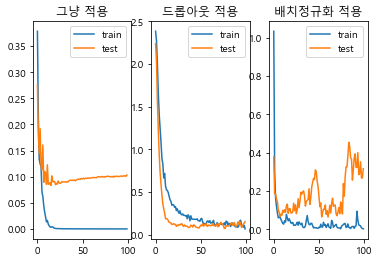

In [135]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.subplot(1,3,1)
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train','test'])
plt.title('그냥 적용')


plt.subplot(1,3,2)
plt.plot(drop_train_losses)
plt.plot(drop_test_losses)
plt.legend(['train','test'])
plt.title('드롭아웃 적용')

plt.subplot(1,3,3)
plt.plot(batch_train_losses)
plt.plot(batch_test_losses)
plt.legend(['train','test'])
plt.title('배치정규화 적용')

In [141]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias = True, p = 0.5):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.drop(x)
        return x

In [142]:
mlp = nn.Sequential(
    CustomLinear(64,200),
    CustomLinear(200,200),
    CustomLinear(200,200),
    nn.Linear(200,10))

In [144]:
class MyMLP(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.ln1 = CustomLinear(in_features, 200)
        self.ln2 = CustomLinear(200, 200)
        self.ln3 = CustomLinear(200, 200)
        self.ln4 = CustomLinear(200, out_features)
        
    def forward(self, x):
        x = self.ln1(x)
        x = self.ln2(x)
        x = self.ln3(x)
        x = self.ln4(x)
        return x

In [145]:
mlp = MyMLP(64,10)